In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
data = pd.read_csv('./Data/H1B_2017.csv', low_memory=False)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622773 entries, 0 to 622772
Data columns (total 13 columns):
Unnamed: 0              622773 non-null int64
employer                622773 non-null object
job_title               622773 non-null object
occupational_name       622773 non-null object
prevailing_wage         622773 non-null float64
pw_wage_period          622773 non-null object
employer_wage           622773 non-null float64
employer_max_wage       622773 non-null float64
employer_wage_period    622773 non-null object
city                    622773 non-null object
county                  622773 non-null object
state                   622773 non-null object
postal_code             622773 non-null object
dtypes: float64(3), int64(1), object(9)
memory usage: 61.8+ MB


In [4]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,employer,job_title,occupational_name,prevailing_wage,pw_wage_period,employer_wage,employer_max_wage,employer_wage_period,city,county,state,postal_code
0,DISCOVER PRODUCTS INC.,ASSOCIATE DATA INTEGRATION,COMPUTER SYSTEMS ANALYSTS,59197.0,Year,65811.0,67320.0,Year,RIVERWOODS,LAKE,IL,60015
1,DFS SERVICES LLC,SENIOR ASSOCIATE,OPERATIONS RESEARCH ANALYSTS,49800.0,Year,53000.0,57200.0,Year,RIVERWOODS,LAKE,IL,60015
2,INFO SERVICES LLC,PROJECT MANAGER,"COMPUTER OCCUPATIONS, ALL OTHER",90376.0,Year,102000.0,0.0,Year,JERSEY CITY,HUDSON,NJ,07302
3,BB&T CORPORATION,ASSOCIATE - ESOTERIC ASSET BACKED SECURITIES,CREDIT ANALYSTS,116605.0,Year,132500.0,0.0,Year,NEW YORK,NEW YORK,NY,10036
4,"SUNTRUST BANKS, INC.",CREDIT RISK METRICS SPECIALIST,"FINANCIAL SPECIALISTS, ALL OTHER",59405.0,Year,71750.0,0.0,Year,ATLANTA,FULTON,GA,30303


In [5]:
data.describe()

,prevailing_wage,employer_wage,employer_max_wage
count,6.227730e+05,6.227730e+05,6.227730e+05
mean,9.971660e+04,1.047551e+05,2.412360e+04
std,1.811748e+06,1.809885e+06,5.253267e+04
min,1.508000e+04,1.500000e+04,0.000000e+00
25%,5.953000e+04,6.500000e+04,0.000000e+00
50%,7.178100e+04,7.785000e+04,0.000000e+00
75%,9.035500e+04,1.000000e+05,0.000000e+00
max,4.013610e+08,3.120000e+08,3.000000e+06


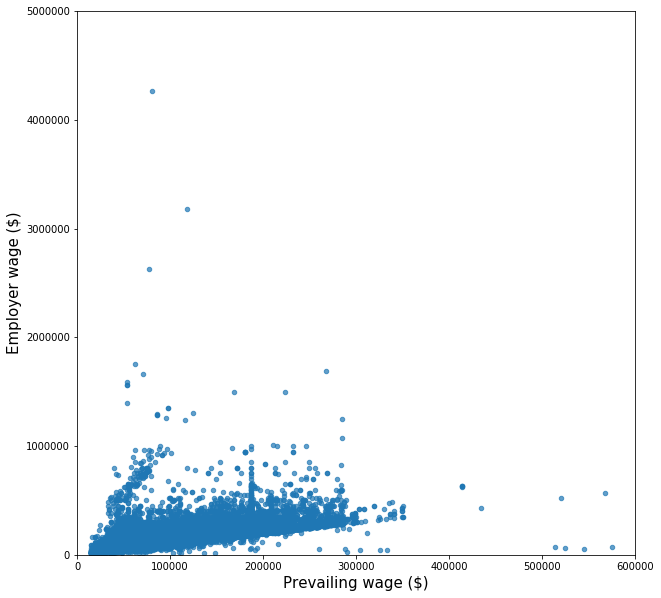

Pearson correlation considering all the data points: 0.0748


In [6]:
plt.figure(figsize=(10,10))
plt.scatter(data.prevailing_wage, data.employer_wage, alpha=0.7, s=20)
plt.xlabel('Prevailing wage ($)', size=15)
plt.xlim(0,600000)
plt.ylabel('Employer wage ($)', size=15)
plt.ylim(0,5000000)
plt.title('')
plt.show()

pearson = np.corrcoef(data.prevailing_wage, data.employer_wage)[0,1]
print("Pearson correlation considering all the data points: %.4f" %pearson)

From the plot above we realize that there is a considerable amount of points, at the top right and botto left, falling outside the common range of values for the prevailing wage and the employer's wage. These points are a potential source of error for the model, so the best option before start developing a model is to remove outliers. using.

# Defining and removing outliers

[Tukey's method](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/) consists on determining the inter-quartile range (IQR) and remove points having values below the first quartile (Q1) minus 1.5 x IQR and points over the third quartile (Q3) plus 1.5 x IQR.  

In [7]:
# Q1 and Q3 of prevailing wage
pr_Q1, pr_Q3 = np.percentile(data.prevailing_wage, [25, 75])
pr_IQR = pr_Q3 - pr_Q1
# Q1 and Q3 of employer wage
em_Q1, em_Q3 = np.percentile(data.employer_wage, [25, 75])
em_IQR = em_Q3 - em_Q1
# Min and Max value for prevailing wage
pr_min = pr_Q1 - 1.5 * pr_IQR
pr_max = pr_Q3 + 1.5 * pr_IQR
# Min and Max value for employer wage
em_min = em_Q1 - 1.5 * em_IQR
em_max = em_Q3 + 1.5 * em_IQR
# Filters to eliminate outliers
pr_filter = (data.prevailing_wage > pr_min) & (data.prevailing_wage < pr_max)
em_filter = (data.employer_wage > em_min) & (data.employer_wage < em_max)

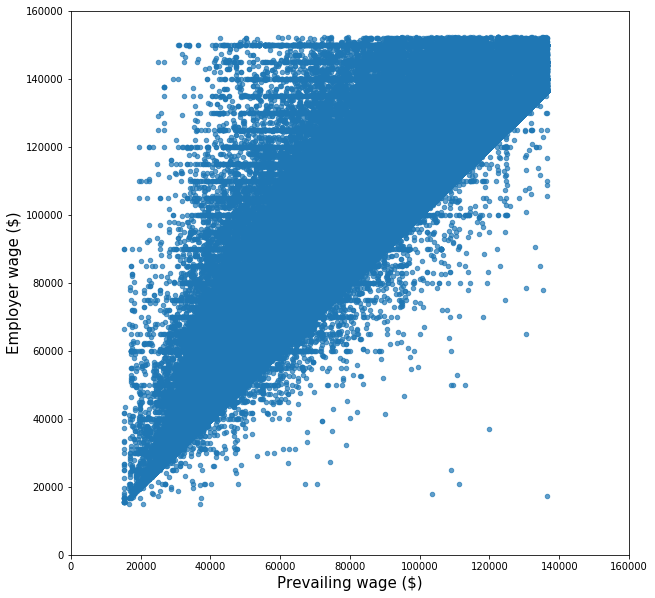

Pearson correlation without outliers per Tukey's criteria: 0.8725


In [8]:
plt.figure(figsize=(10,10))
plt.scatter(data.prevailing_wage[pr_filter & em_filter], \
            data.employer_wage[pr_filter & em_filter], alpha=0.7, s=20)
plt.xlabel('Prevailing wage ($)', size=15)
plt.xlim(0,160000)
plt.ylabel('Employer wage ($)', size=15)
plt.ylim(0,160000)
plt.title('')
plt.show()

new_pearson = np.corrcoef(data.prevailing_wage[pr_filter & em_filter], \
                      data.employer_wage[pr_filter & em_filter])[0,1]
print("Pearson correlation without outliers per Tukey's criteria: %.4f" %new_pearson)

Let's define an arbitrary resonable criteria of a maximum of $300K for the salaries to compare with Tukey's criteria.

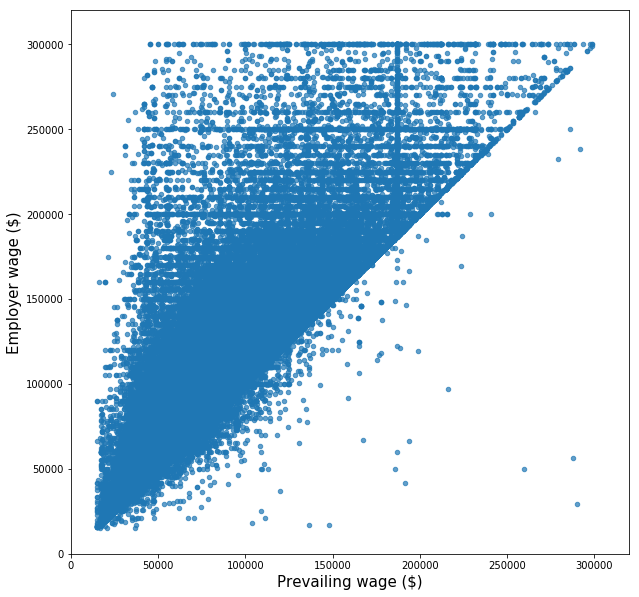

Pearson correlation considering points below $300K: 0.8633


In [9]:
# Filter of $300K for prevailing and employer wage
filter1 = (data.prevailing_wage<=300000) & (data.employer_wage<=300000)

plt.figure(figsize=(10,10))
plt.scatter(data.prevailing_wage[filter1], \
            data.employer_wage[filter1], alpha=0.7, s=20)
plt.xlabel('Prevailing wage ($)', size=15)
plt.xlim(0,320000)
plt.ylabel('Employer wage ($)', size=15)
plt.ylim(0,320000)
plt.title('')
plt.show()

new_pearson = np.corrcoef(data.prevailing_wage[filter1], \
                      data.employer_wage[filter1])[0,1]
print("Pearson correlation considering points below $300K: %.4f" %new_pearson)

If we define the data to develop the model without the outliers per the Tukey's criteria we obtain: 

In [10]:
# Selecting possible features to train model
columns = ['job_title', 'occupational_name', 'prevailing_wage', 'city', 'county', 'state', 'postal_code']
features = data[columns]
# Selecting data
X = features[pr_filter & em_filter].reset_index(drop=True)
# Selecting target
y = data.employer_wage[pr_filter & em_filter].reset_index(drop=True)
# Print number of possible values per feature target
print("Using Tukey's criteria:")
for col in columns:
    print("\t Number of unique values for column -{}- : {}".format(col, len(X[col].unique())))
print("\t Number of unique values for column -employer_wage- : {}".format(len(y.unique())))

Using Tukey's criteria:
	 Number of unique values for column -job_title- : 84724
	 Number of unique values for column -occupational_name- : 849
	 Number of unique values for column -prevailing_wage- : 19900
	 Number of unique values for column -city- : 7652
	 Number of unique values for column -county- : 3550
	 Number of unique values for column -state- : 57
	 Number of unique values for column -postal_code- : 12177
	 Number of unique values for column -employer_wage- : 44632


If we define the data to develop the model without the outliers per the $300K criteria we obtain: 

In [11]:
# Selecting data
X = features[filter1].reset_index(drop=True)
# Selecting target
y = data.employer_wage[filter1].reset_index(drop=True)
# Print number of possible values per feature target
print('Using the $300K:')
for col in columns:
    print("\t Number of unique values for column -{}- : {}".format(col, len(X[col].unique())))
print("\t Number of unique values for column -employer_wage- : {}".format(len(y.unique())))

Using the $300K:
	 Number of unique values for column -job_title- : 92349
	 Number of unique values for column -occupational_name- : 865
	 Number of unique values for column -prevailing_wage- : 23636
	 Number of unique values for column -city- : 7915
	 Number of unique values for column -county- : 3652
	 Number of unique values for column -state- : 57
	 Number of unique values for column -postal_code- : 12609
	 Number of unique values for column -employer_wage- : 50125


In [12]:
print("Number of points for the whole data set: {}".format(len(data)))
print("Number of points for salaries with Tukey's criteria: {}".format(len(data[pr_filter & em_filter])))
print("Number of points for salaries with the $300K criteria: {}".format(len(data[filter1])))

Number of points for the whole data set: 622773
Number of points for salaries with Tukey's criteria: 588762
Number of points for salaries with the $300K criteria: 620729


Eliminating outliers using Tukey's criteria results in a slightly better correlation between the prevailing wage and the employer wage compared to the \$300K criteria, 0.8725 against 0.8633. However Tukey's criteria diminishes considerably the number of possible values per category compared to the \$300K criteria and eliminates 5.46% of the original data while the $300K criteria only eliminates 0.33% of the data points. For this reason, the best option to develop the model is using the \$300K criteria.


In [13]:
# Selecting possible features to train model
columns = ['job_title', 'occupational_name', 'prevailing_wage', 'city', 'county', 'state', 'postal_code']
features = data[columns]
# Selecting data
X = features[pr_filter & em_filter].reset_index(drop=True)
# Selecting target
y = data.employer_wage[pr_filter & em_filter].reset_index(drop=True)

-------------------------------

# Defining testing and validation sets

Let's define the training and validation set as well as a seed for the random operations in order to preserve reproducibility:

In [14]:
# Definition of random parameters
seed = 14
np.random.seed(seed)

In [15]:
from sklearn.model_selection import train_test_split

# Creating testing and training sets
X_train, X_val, y_train, y_val = \
                    train_test_split(X, y, test_size=0.20, random_state=seed)

-------------------------------------

-------------------------------------

# Splitting training data

Let's remember that the purpose of this project is to predict employer's wage. The data contains prevailing wage but it is a fair assumption to consider that most probably a person trying to define her wage is not aware of the prevailing wage given that this one is defined by the US Department of Labor in a case by case base.

It was shown above that prevaling wage and employer wage are highly correlated, indicating that a variance in prevailing wage causes a strong variance in employer wage. Then it appears as a good choice to use prevailing wage as one predictor fro employer wage.

Given that in most cases prevailing wage will be unknown by a user of the model, the first step is to predict prevailing wage and then use the predicted prevailing wage to determine employer wage. For this reason, the training sets are divided in two:
- A set to predict in a first step prevailing wage;
- And a set finally develop the model to predict employer wage.

In [16]:
# Lenght of new sets
len_train = int(len(X_train)/2)
# Set to predict prevailing wage
pr_X = X_train[:len_train]
pr_y_ = y_train[:len_train]
# Set to predict employer wage
em_X = X_train[len_train:]
em_y = y_train[len_train:]

-------------------------------

# Model 1: Predict prevailing wage

For this model, that we call model 1, we don't need the employer wage so we redefine the first set defined above and we split it set into a training and test set. In this case the target is the prevailing wage that is contained in pr_X and the target is the natural logarithm the prevailing wage. After redefining the set we again split it between train and test set for model 1.

In [17]:
# Target
pr_y_log = np.log(pr_X.prevailing_wage)
# Features
pr_X = pr_X.drop(['prevailing_wage'], axis=1)

In [18]:
# Train and test sets
pr_X_train, pr_X_test, pr_y_train, pr_y_test = \
                    train_test_split(pr_X, pr_y_log, test_size=0.20, random_state=seed)

### Model 1 - Method 1: encode text from categorical columns in sparse vectors

The features avalaible to predict prevailing wage are categorical, then we treat them as words. The first approach is to merge per column the features by preserving the space between words and creating a TF-IDF vectorizer describing the new merged features. 

We also create a benchmark model, in this case a linear regression, to be able to compare the model later. 

In [19]:
# Merging columns per row
pr_X_train['merged'] = pr_X.job_title + " " + pr_X.occupational_name + " " + pr_X.city \
                    + " " + pr_X.county + " " + pr_X.state + " " + pr_X.postal_code

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Benchmark model: standard linear regression

We do first a cross validation grid search on the TF-IDF vectorizer to check if it is worth to coonsider an n-gram model.

In [20]:
from sklearn.model_selection import KFold
# Defining cross validation object
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from time import time

# Define pipeline and steps
steps = [('vect', TfidfVectorizer(sublinear_tf=True)), # Word vectorizer
         ('linr', LinearRegression())]
pipeline = Pipeline(steps)
# Parameters for grid search
parameters = {'vect__ngram_range': [(1, 1), (1,2), (1,3)]}
# Define grid search
grid_search = GridSearchCV(pipeline, param_grid=parameters, cv=cv, scoring='neg_mean_absolute_error')
# Train
start = time()
grid_search.fit(pr_X_train.merged, pr_y_train)
end = time()

print("Grid-search time: %.3f" %(end-start))
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Grid-search time: 2521.348
Best score: -0.146
Best parameters set:
	vect__ngram_range: (1, 1)


From the grid search the best n-gram is (1,1), meaning that using an n-gram vectorizer doesn't improve the model. Knowing this, the model is now trained in the full test data set.

In [22]:
# Define pipeline and steps
steps = [('vectorizer', TfidfVectorizer(sublinear_tf=True)), # Word vectorizer
         ('regressor', LinearRegression())]
benchmark_pipeline = Pipeline(steps)
# Train
start = time()
benchmark_pipeline.fit(pr_X_train.merged, pr_y_train)
end = time()
print("Linear Regressor training time: %.3fs" %(end-start))

Linear Regressor training time: 24.955s


In [23]:
from sklearn.metrics import mean_absolute_error

# Test data to merged form
pr_X_test['merged'] = pr_X.job_title + " " + pr_X.occupational_name + " " + pr_X.city \
                    + " " + pr_X.county + " " + pr_X.state + " " + pr_X.postal_code
# Prediction by the model
pr_X_test_pred = benchmark_pipeline.predict(pr_X_test.merged)
# Error on natural log data
benchmark_error = mean_absolute_error(pr_y_test, pr_X_test_pred)
print("Benchmark model - LinearRegressor:")
print("\t Mean absolute error in natural log values: %.3f" %benchmark_error)
# Error on real data
pr_X_test_pred_real = np.exp(pr_X_test_pred)
pr_y_test_real = np.exp(pr_y_test)
benchmark_error_real = mean_absolute_error(pr_y_test_real, pr_X_test_pred_real)
print("\t Mean absolute error in dollars: $%.3f" %benchmark_error_real)

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Benchmark model - LinearRegressor:
	 Mean absolute error in natural log values: 0.145
	 Mean absolute error in dollars: $10580.366


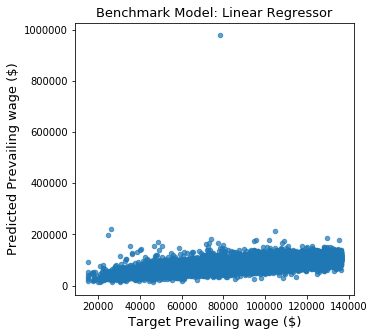

In [24]:
plt.figure(figsize=(5,5))
plt.scatter(pr_y_test_real, pr_X_test_pred_real, alpha=0.7, s=20)
plt.xlabel('Target Prevailing wage ($)', size=13)
plt.ylabel('Predicted Prevailing wage ($)', size=13)
plt.title('Benchmark Model: Linear Regressor', size=13)
plt.show()

The benchmark model has an absolut error of less than $10,600. Now the purpose is to create a model lowering that error.

#### Improving over benchmark model

The plot above showing several points with a predicted prevailing wage higher than the target, suggests that the outliers in the data, which were not totally removed given that we chose as a criteria salaries less than $300K, played a role when fitting the model. To deal appropriately with those outliers a [Hubert regressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html) is proposed.

**a. Huber regressor:**

In [25]:
from sklearn.linear_model import HuberRegressor

# Define pipeline
steps1 = [('vect1', TfidfVectorizer(sublinear_tf=True)), # Word vectorizer
         ('hubr', HuberRegressor(max_iter=600))]
pipeline1 = Pipeline(steps1)
# Grid search parameters
parameters = {'hubr__epsilon': [1, 1.05, 1.15, 1.25],
              'hubr__alpha': [0, 0.1, 0.01]}
#Grid search
grid_search = GridSearchCV(pipeline1, param_grid=parameters, cv=cv, scoring='neg_mean_absolute_error')

start = time()
grid_search.fit(pr_X_train.merged, pr_y_train)
end = time()

print("Grid-search time: %.3f" %(end-start))
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Grid-search time: 2061.916
Best score: -0.142
Best parameters set:
	hubr__alpha: 0.1
	hubr__epsilon: 1


Having determined the best optimal parameters for the Hubert regressor, now we proceed to use all the training data to fit the Hubert regressor model for prevailing wage prediction.

In [26]:
# Define pipeline
steps1 = [('vect1', TfidfVectorizer(sublinear_tf=True)), # Word vectorizer
         ('hubr', HuberRegressor(alpha=0.1, epsilon=1, max_iter=700))]
pipeline1 = Pipeline(steps1)
# Train
start = time()
pipeline1.fit(pr_X_train.merged, pr_y_train)
end = time()
print("Huber Regressor training time: %.3fs" %(end-start))

Huber Regressor training time: 39.308s


In [28]:
# Prediction by the model
pr_pred1 = pipeline1.predict(pr_X_test.merged)
# Error on natural log data
pipeline1_error = mean_absolute_error(pr_y_test, pr_pred1)
print("Benchmark model - LinearRegressor:")
print("\t Mean absolute error in natural log values: %.3f" %pipeline1_error)
# Error on real data
pr_pred1_real = np.exp(pr_pred1)
pipeline1_error_real = mean_absolute_error(pr_y_test_real, pr_pred1_real)
print("\t Mean absolute error in dollars: $%.3f" %pipeline1_error_real)

Benchmark model - LinearRegressor:
	 Mean absolute error in natural log values: 0.141
	 Mean absolute error in dollars: $10237.536


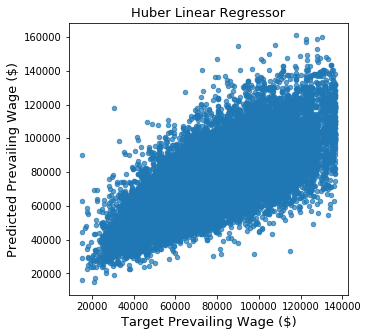

In [29]:
plt.figure(figsize=(5,5))
plt.scatter(pr_y_test_real, pr_pred1_real, alpha=0.7, s=20)
plt.xlabel('Target Prevailing Wage ($)', size=13)
plt.ylabel('Predicted Prevailing Wage ($)', size=13)
plt.title('Huber Linear Regressor', size=13)
plt.show()

The Hubert regressor, which is well suited when dealing with, outliers slightly outperforms the linear regressor resulting in an average mean absolute error of $10,237.536.

Keeping this in mind, in the search for the most appropriate model, given that all the features are categorical, let's try a random forest regressor that avoids merging all the features into one column as we did previously.

**b. Random forest:**

The use of random forest or any other three regression algorithm from scikit-learn requires numerical labels. To do this, it is enough to count the number of different labels in a category and assign a number to each label. However this numerical encoding can be translated into giving more importance to labels with higher assigned number which can introduce a bias to the algortihm. To deal with this issue, the most common labels in a category are assigned higher levels.

First we create a dictionary where the keys are the features or variables and the values contain the respective numerical mapping.

In [62]:
# Dictionary containing mapping codes for each feature
coding_dic = {}
for column in pr_X.columns:
    # Counting values 
    map_counts = pr_X_train[column].value_counts()
    # Assign maximum value to most common label
    coding_dic[column] = dict(zip(map_counts.index, np.arange(map_counts.shape[0] - 1, -1, -1)))

In [63]:
# Function adding encoded columns to data set
def encode_feats(df, coding_dic):
    feats_encoded = []
    for feat in coding_dic.keys():
        feat_dict = coding_dic[feat]
        df[feat+'_enc'] = df[feat].map(feat_dict)
        feats_encoded.append(feat+'_enc')
    return feats_encoded

In [64]:
# Apply encode_feats to training data
feats_enc = encode_feats(pr_X_train, coding_dic)
pr_X_train.head()

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,job_title,occupational_name,city,county,state,postal_code,merged,job_title_enc,occupational_name_enc,city_enc,county_enc,state_enc,postal_code_enc
130885,ASSISTANT PROFESSOR,"POLITICAL SCIENCE TEACHERS, POSTSECONDARY",FORT WORTH,TARRANT,TX,76129,ASSISTANT PROFESSOR POLITICAL SCIENCE TEACHERS...,37029,473,5012,2264,54,4461
462144,COMPUTER PROGRAMMER,COMPUTER PROGRAMMERS,AURORA,DUPAGE,IL,60504,COMPUTER PROGRAMMER COMPUTER PROGRAMMERS AUROR...,37034,640,4926,2263,51,8631
531234,BUSINESS INFORMATION DEVELOPER SENIOR,"COMPUTER OCCUPATIONS, ALL OTHER",NORFOLK,NORFOLK CITY,VA,23502,BUSINESS INFORMATION DEVELOPER SENIOR COMPUTER...,6630,639,4920,2168,44,8677
138086,PROGRAMMER ANALYST,COMPUTER SYSTEMS ANALYSTS,BOSTON,SUFFOLK,MA,02111,PROGRAMMER ANALYST COMPUTER SYSTEMS ANALYSTS B...,37039,641,5061,2295,50,8760
76254,SYSTEMS DEVELOPMENT SPECIALIST,"SOFTWARE DEVELOPERS, APPLICATIONS",LEWISVILLE,DENTON,TX,75067,SYSTEMS DEVELOPMENT SPECIALIST SOFTWARE DEVELO...,35676,642,4847,2235,54,8412


In [108]:
## from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=20)
start = time()
forest.fit(pr_X_train[feats_enc], pr_y_train)
end = time()

print("Random Forest training time: %.3fs" %(end-start))

Random Forest training time: 39.132s


In [66]:
# Apply encode_feats to test data
feats_enc = encode_feats(pr_X_test, coding_dic)
pr_X_test.fillna(-1, inplace=True)

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [109]:
# Prediction by the model
pr_pred_forest = forest.predict(pr_X_test[feats_enc])
# Error on natural log data
forest_error = mean_absolute_error(pr_y_test, pr_pred_forest)
print("Random Forest:")
print("\t Mean absolute error in natural log values: %.3f" %forest_error)
# Error on real data
pr_pred_forest_real = np.exp(pr_pred_forest)
forest_error_real = mean_absolute_error(pr_y_test_real, pr_pred_forest_real)
print("\t Mean absolute error in dollars: $%.3f" %forest_error_real)

Random Forest:
	 Mean absolute error in natural log values: 0.129
	 Mean absolute error in dollars: $9361.905


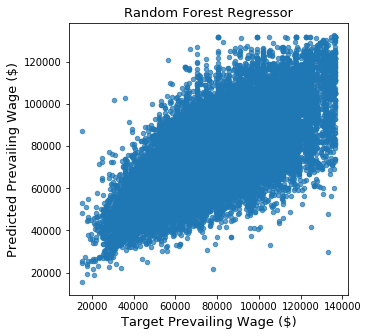

In [124]:
plt.figure(figsize=(5,5))
plt.scatter(pr_y_test_real, pr_pred_forest_real, alpha=0.7, s=20)
plt.xlabel('Target Prevailing Wage ($)', size=13)
plt.ylabel('Predicted Prevailing Wage ($)', size=13)
plt.title('Random Forest Regressor', size=13)
plt.show()

--------------------------

# Model 2: Predict employer wage

In this second part of the project, now that there is a model to predict prevailing wages, the purpose is to build a model to predict the final target which is the employer wage.

This part has three steps that allow to extract some insight on the validity of the final predicted wages. First a model predicting the employer wage with the prevailing wage from the original data set is built and tested. Then, a similar model is built but prevailing wages predicted from model 1. Finally, for comparison a model predicting employer wage whitout accounting for prevailing wage is built.

In all the three steps, the common feature variables are state and postal_code. We assume that the information about job titles and categories is carried by the prevailing wage. Of course this will not apply for the third step that will only consider state and postal_code to make a prediction.

## Step 1: Predict employer wage using prevailing wage from original data set

At the beginning the features and target for emplyer wage were defined as shown below:

In [30]:
# Set to predict employer wage
# em_X = X_train[len_train:]
# em_y = y_train[len_train:]
em_X.head()

,job_title,occupational_name,prevailing_wage,city,county,state,postal_code
407096,QUALITY ASSURANCE ANALYST,COMPUTER PROGRAMMERS,52874.0,NASHVILLE,DAVIDSON,TN,37203
64645,SENIOR CONSULTANT,COMPUTER SYSTEMS ANALYSTS,66373.0,INDIANAPOLIS,MARION,IN,46204
415539,IT APPLICATION DEVELOPMENT LEAD,"SOFTWARE DEVELOPERS, APPLICATIONS",71843.0,CHICAGO,COOK,IL,60601
73658,IT PROJECT MANAGER,INFORMATION TECHNOLOGY PROJECT MANAGERS,57470.0,BARTLESVILLE,WASHINGTON,OK,74003
88817,TECHNOLOGY ANALYST - US,COMPUTER SYSTEMS ANALYST,76835.0,SAN FRANCISCO,SAN FRANCISCO,CA,94105


As before, the numerical variables are expressed in natural logarithm form.

In [31]:
# Add natural log of prevailing wage
em_X['pw_log'] = np.log(em_X.prevailing_wage)
em_y_log = np.log(em_y)
em_X.head()

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,job_title,occupational_name,prevailing_wage,city,county,state,postal_code,pw_log
407096,QUALITY ASSURANCE ANALYST,COMPUTER PROGRAMMERS,52874.0,NASHVILLE,DAVIDSON,TN,37203,10.875667
64645,SENIOR CONSULTANT,COMPUTER SYSTEMS ANALYSTS,66373.0,INDIANAPOLIS,MARION,IN,46204,11.103046
415539,IT APPLICATION DEVELOPMENT LEAD,"SOFTWARE DEVELOPERS, APPLICATIONS",71843.0,CHICAGO,COOK,IL,60601,11.182238
73658,IT PROJECT MANAGER,INFORMATION TECHNOLOGY PROJECT MANAGERS,57470.0,BARTLESVILLE,WASHINGTON,OK,74003,10.959018
88817,TECHNOLOGY ANALYST - US,COMPUTER SYSTEMS ANALYST,76835.0,SAN FRANCISCO,SAN FRANCISCO,CA,94105,11.249416


In [32]:
# Train and test sets
em_X_train, em_X_test, em_y_train, em_y_test = \
                    train_test_split(em_X, em_y_log, test_size=0.20, random_state=seed)

The amount of data being significant, an SGDRegressor allowing partial_fit is proposed. The partial_fit method permits training the model by batches. The batches are created using the function below:

In [33]:
def batches(size, X, y):
    # This function transform data into batches
    batch_start = 0
    n_points = X.shape[0]
    while batch_start < n_points:
        batch_end = batch_start + size
        if batch_end < n_points:
            X_batch = X.iloc[range(batch_start, batch_end)]
            y_batch = y.iloc[range(batch_start, batch_end)]
        else:
            X_batch = X.iloc[range(batch_start,n_points)]
            y_batch = y.iloc[range(batch_start, n_points)]
        yield X_batch, y_batch
        batch_start += size

We retain only postal_code, state and prevailing wage in natural log form.

In [34]:
features1=['state', 'postal_code', 'pw_log']

The features state and postal_code are categorical variables, so it is necessary to perform one-hot encoding on them. For this task the OneHotEncoder method from [dummyPy](https://github.com/yashu-seth/dummyPy) is used. This package has the advantage of handling labels directly, so categorical variable doesn't need to be turned into numerical values first.

In [35]:
from dummyPy import OneHotEncoder

# Create one-hot encoder and fit it to the data
encoder = OneHotEncoder(['postal_code', 'state'])
encoder.fit(em_X_train[features1])

In [36]:
from sklearn.linear_model import SGDRegressor

# Set parameters for batch training
batch_size = 20000
# Create regressor
regressor1 = SGDRegressor(max_iter=600, random_state=seed)
# Get batches
train_batches = batches(batch_size, em_X_train[features1], em_y_train)

# Start training
start = time() #start time
for X_batch, y_batch in train_batches:
    # Transform batch to one-hot encoding
    X_batch_trans = encoder.transform(X_batch)
    # Partial fit
    regressor1.partial_fit(X_batch_trans, y_batch)
end = time() #end time

regressor_name = regressor1.__class__.__name__
print("%s training time: %.3fs" %(regressor_name, end-start))

SGDRegressor training time: 297.194s


In [37]:
# Predict on test set
test_batches = batches(batch_size, em_X_test[features1], em_y_test)
y_pred_wage = []
for X_batch, y_batch in test_batches:
    X_test_trans = encoder.transform(X_batch)
    y_pred_wage.extend(regressor1.predict(X_test_trans))
    
# Calculate mean absolute error
mean_error_log = mean_absolute_error(em_y_test, y_pred_wage)
print("Step 1 - SGDRegressor:")
print("\t Mean absolute error in natural log values: %.3f" % mean_error_log)
# Values in dollars
em_y_test_real = np.exp(em_y_test)
y_pred_wage_real = np.exp(y_pred_wage)
mean_error_real = mean_absolute_error(em_y_test_real, y_pred_wage_real)
print("\t Mean absolute error: $%.3f" % mean_error_real)

Step 1 - SGDRegressor:
	 Mean absolute error in natural log values: 0.099
	 Mean absolute error: $7936.559


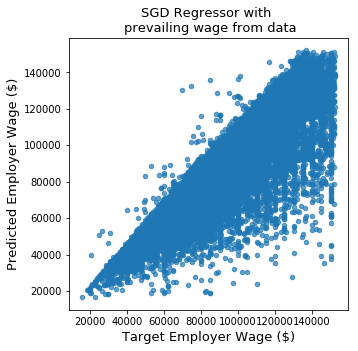

In [38]:
plt.figure(figsize=(5,5))
plt.scatter(em_y_test_real, y_pred_wage_real, alpha=0.7, s=20)
plt.xlabel('Target Employer Wage ($)', size=13)
plt.ylabel('Predicted Employer Wage ($)', size=13)
plt.title('SGD Regressor with \n prevailing wage from data', size=13)
plt.show()

## Step 2: Predict employer wage using predicted prevailing wage from model 1

It is necessary to define a function predicting prevailing wage using model 1. Let's remember that model 1 predicts prevailing wage in natural logarithm form, which is suitable in this situation.

In [39]:
def predict_pw_log(data):
    # Merge categorical variables into one string
    merged = data.job_title + " " + data.occupational_name + " " \
                        + data.city + " " + data.county + " " + data.state \
                        + " " + data.postal_code
    # predict prevailing wage using model 1 (Huber regressor)
    prediction = pipeline1.predict(merged)
    
    return prediction

Let's add the prevailing wage predictions to the training set.

In [40]:
em_X_train['pw_pred_log'] = predict_pw_log(em_X_train)
em_X_train.head()

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,job_title,occupational_name,prevailing_wage,city,county,state,postal_code,pw_log,pw_pred_log
370405,CIVIL ENGINEER (ENERGY),CIVIL ENGINEERS,73715.0,SOUTH SAN FRANCISCO,SAN MATEO,CA,94080,11.207962,11.225247
512622,SENIOR ADVERTISING ANALYST,COMPUTER SYSTEMS ANALYSTS,116522.0,SAN JOSE,SANTA CLARA,CA,95125,11.665835,11.481089
485279,VISITING ASSISTANT PROFESSOR,"ECONOMICS TEACHERS, POSTSECONDARY",37790.0,BATON ROUGE,EAST BATON ROUGE,LA,70803,10.539800,10.742049
95803,SYSTEMS ANALYST,COMPUTER SYSTEMS ANALYSTS,60320.0,LANSING,EATON,MI,48913,11.007419,10.956186
297904,PROGRAMMER ANALYST,"SOFTWARE DEVELOPERS, APPLICATIONS",73590.0,HAMILTON,MERCER,NJ,08619,11.206264,11.207173


In [41]:
features2 = ['state', 'postal_code', 'pw_pred_log']

In [42]:
# Set parameters for batch training
batch_size = 20000
# Create regressor
regressor2 = SGDRegressor(max_iter=600, random_state=seed)
# Get batches
train_batches = batches(batch_size, em_X_train[features2], em_y_train)

# Start training
start = time() #start time
for X_batch, y_batch in train_batches:
    # Transform batch to one-hot encoding
    X_batch_trans = encoder.transform(X_batch)
    # Partial fit
    regressor2.partial_fit(X_batch_trans, y_batch)
end = time() #end time

regressor_name = regressor2.__class__.__name__
print("%s training time: %.3fs" %(regressor_name, end-start))

SGDRegressor training time: 321.349s


In [43]:
# Predict prevailing wage on test set
em_X_test['pw_pred_log'] = predict_pw_log(em_X_test)
# Predict on test set using features2
test_batches = batches(batch_size, em_X_test[features2], em_y_test)
y_pred_wage_2 = []
for X_batch, y_batch in test_batches:
    X_test_trans = encoder.transform(X_batch)
    y_pred_wage_2.extend(regressor2.predict(X_test_trans))
    
# Calculate mean absolute error
mean_error_log_2 = mean_absolute_error(em_y_test, y_pred_wage_2)
print("Step 2 - SGDRegressor:")
print("\t Mean absolute error in natural log values: %.3f" % mean_error_log_2)
# Values in dollars
y_pred_wage_real_2 = np.exp(y_pred_wage_2)
mean_error_real_2 = mean_absolute_error(em_y_test_real, y_pred_wage_real_2)
print("\t Mean absolute error: $%.3f" % mean_error_real_2)

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Step 2 - SGDRegressor:
	 Mean absolute error in natural log values: 0.160
	 Mean absolute error: $13082.062


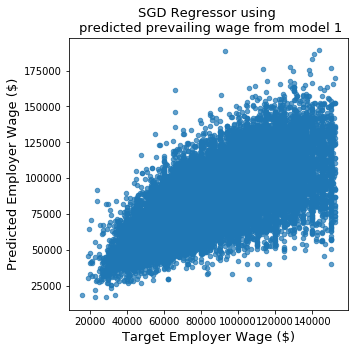

In [44]:
plt.figure(figsize=(5,5))
plt.scatter(em_y_test_real, y_pred_wage_real_2, alpha=0.7, s=20)
plt.xlabel('Target Employer Wage ($)', size=13)
plt.ylabel('Predicted Employer Wage ($)', size=13)
plt.title('SGD Regressor using \n predicted prevailing wage from model 1', size=13)
plt.show()

As expected the error is higher than the model from step 1, however by comparing the plots of step 1 and 2, 

## Step 3: Predict employer wage using only postal_code and state

In [45]:
features3 = ['state', 'postal_code']

In [46]:
# Set parameters for batch training
batch_size = 20000
# Create regressor
regressor3 = SGDRegressor(max_iter=600, random_state=seed)
# Get batches
train_batches = batches(batch_size, em_X_train[features3], em_y_train)

# Start training
start = time() #start time
for X_batch, y_batch in train_batches:
    # Transform batch to one-hot encoding
    X_batch_trans = encoder.transform(X_batch)
    # Partial fit
    regressor3.partial_fit(X_batch_trans, y_batch)
end = time() #end time

regressor_name = regressor3.__class__.__name__
print("%s training time: %.3fs" %(regressor_name, end-start))

SGDRegressor training time: 331.507s


In [47]:
# Predict on test set using features3
test_batches = batches(batch_size, em_X_test[features3], em_y_test)
y_pred_wage_3 = []
for X_batch, y_batch in test_batches:
    X_test_trans = encoder.transform(X_batch)
    y_pred_wage_3.extend(regressor3.predict(X_test_trans))
    
# Calculate mean absolute error
mean_error_log_3 = mean_absolute_error(em_y_test, y_pred_wage_3)
print("Step 3 - SGDRegressor:")
print("\t Mean absolute error in natural log values: %.3f" % mean_error_log_3)
# Values in dollars
y_pred_wage_real_3 = np.exp(y_pred_wage_3)
mean_error_real_3 = mean_absolute_error(em_y_test_real, y_pred_wage_real_3)
print("\t Mean absolute error: $%.3f" % mean_error_real_3)

Step 3 - SGDRegressor:
	 Mean absolute error in natural log values: 0.218
	 Mean absolute error: $17589.771


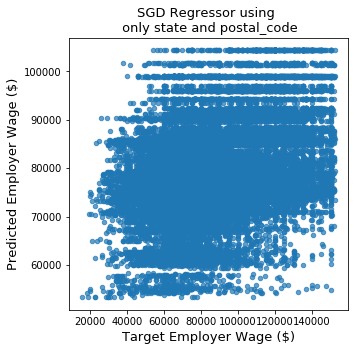

In [48]:
plt.figure(figsize=(5,5))
plt.scatter(em_y_test_real, y_pred_wage_real_3, alpha=0.7, s=20)
plt.xlabel('Target Employer Wage ($)', size=13)
plt.ylabel('Predicted Employer Wage ($)', size=13)
plt.title('SGD Regressor using \n only state and postal_code', size=13)
plt.show()

The error found in this steps doubles the error from step 1 and is 43% higher than the error from step 2. This confirms that prevailing wage is necessary to predict employer wage.

##  Step 4: predict employer wage as in model 1 without considering prevailing wage

As for model 1, a column merging the strings from the other columns is created.

In [49]:
em_X_train['merged'] = em_X_train.job_title + " " + em_X_train.occupational_name + " " \
                        + em_X_train.city + " " + em_X_train.county + " " + em_X_train.state \
                        + " " + em_X_train.postal_code
em_X_test['merged'] = em_X_test.job_title + " " + em_X_test.occupational_name + " " \
                        + em_X_test.city + " " + em_X_test.county + " " + em_X_test.state \
                        + " " + em_X_test.postal_code

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [50]:
# Define pipeline
steps4 = [('vect4', TfidfVectorizer(sublinear_tf=True)), # Word vectorizer
         ('hubr4', HuberRegressor(alpha=0.1, epsilon=1, max_iter=700))]
pipeline4 = Pipeline(steps4)
# Train
start = time()
pipeline4.fit(em_X_train.merged, em_y_train)
end = time()
print("Huber Regressor training time: %.3fs" %(end-start))

Huber Regressor training time: 43.355s


In [51]:
# Prediction by the model
y_pred_wage_4 = pipeline4.predict(em_X_test.merged)
# Error on natural log data
pipeline4_error = mean_absolute_error(em_y_test, y_pred_wage_4)
print("Step 4: Huber Regressor:")
print("\t Mean absolute error in natural log values: %.3f" %pipeline4_error)
# Error on real data
y_pred_wage_4_real = np.exp(y_pred_wage_4)
pipeline4_error_real = mean_absolute_error(em_y_test_real, y_pred_wage_4_real)
print("\t Mean absolute error in dollars: $%.3f" %pipeline4_error_real)

Step 4: Huber Regressor:
	 Mean absolute error in natural log values: 0.145
	 Mean absolute error in dollars: $11950.345


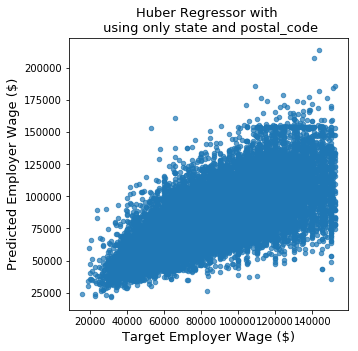

In [52]:
plt.figure(figsize=(5,5))
plt.scatter(em_y_test_real, y_pred_wage_4_real, alpha=0.7, s=20)
plt.xlabel('Target Employer Wage ($)', size=13)
plt.ylabel('Predicted Employer Wage ($)', size=13)
plt.title('Huber Regressor with \n using only state and postal_code', size=13)
plt.show()

--------------------------------------

# Testing model in test set

At the beginning, before splitting the data in two separate sets to train each model, it was splitted into a global training and validation set. Now the developed models are tested using that global validation set. 

In [53]:
X_val.head()

,job_title,occupational_name,prevailing_wage,city,county,state,postal_code
313657,IT ADMINISTRATOR,"COMPUTER OCCUPATIONS, ALL OTHER",54434.0,LAS VEGAS,CLARK,NV,89119
376076,SOLUTIONS ENGINEER,COMPUTER SYSTEMS ANALYSTS,58802.0,ARLINGTON,TARRANT,TX,76006
29319,DEVELOPER USER INTERFACE,WEB DEVELOPERS,63419.0,DEERFIELD,LAKE,IL,60015
137424,APPLICATIONS ENGINEER,MECHANICAL ENGINEERS,93454.0,FARMINGTON,HARTFORD,CT,06032
104835,ORACLE FUNCTIONAL ANALYST,COMPUTER PROGRAMMERS,55910.0,NEW YORK,NEW YORK,NY,10017


In [54]:
y_val.head()

313657    65000.0
376076    60000.0
29319     63419.0
137424    95000.0
104835    70000.0
Name: employer_wage, dtype: float64

It is necessary to create first the merged column.

In [55]:
X_val['merged'] = X_val.job_title + " " + X_val.occupational_name + " " \
                        + X_val.city + " " + X_val.county + " " + X_val.state \
                        + " " + X_val.postal_code

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Test 1: Predict prevailing wage then salary

In this first test we use model 1 to predict prevailing wage because it is fair assumption that someone willing to predict a salary would be unaware of the prevailing wage. After predicting prevailing wage we proceed to predict the final salary or employer wage.

In [56]:
X_val['pw_pred_log'] = predict_pw_log(X_val)

/home/pfgr/anaconda3/envs/h1b/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [57]:
# features2 = ['state', 'postal_code', 'pw_pred_log']

# Predict on validation set using features2
test_batches = batches(batch_size, X_val[features2], y_val)
y_val_pred_wage1 = []
for X_batch, y_batch in test_batches:
    X_test_trans = encoder.transform(X_batch)
    y_val_pred_wage1.extend(regressor2.predict(X_test_trans))
    
# Values in dollars
y_val_pred_wage1_real = np.exp(y_val_pred_wage1)
val_mean_error_real_1 = mean_absolute_error(y_val, y_val_pred_wage1_real)
print("\t Mean absolute error: $%.3f" % val_mean_error_real_1)

	 Mean absolute error: $12981.897


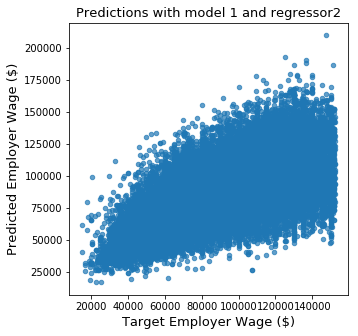

In [58]:
plt.figure(figsize=(5,5))
plt.scatter(y_val, y_val_pred_wage1_real, alpha=0.7, s=20)
plt.xlabel('Target Employer Wage ($)', size=13)
plt.ylabel('Predicted Employer Wage ($)', size=13)
plt.title('Predictions with model 1 and regressor2', size=13)
plt.show()

## Step 2: Predict salary directly from categorical variables only 

In [59]:
# Prediction by categorical features from pipeline4
y_val_pred_wage2 = pipeline4.predict(X_val.merged)
# Error on real data
y_val_pred_wage2_real = np.exp(y_val_pred_wage2)
val_pipeline4_error_real = mean_absolute_error(y_val, y_val_pred_wage2_real)
print("\t Mean absolute error in dollars: $%.3f" %val_pipeline4_error_real)

	 Mean absolute error in dollars: $11856.269


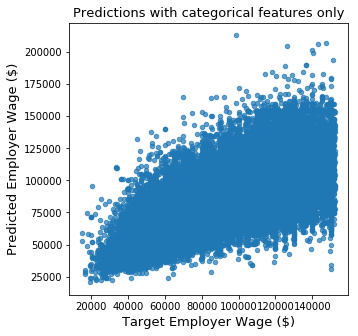

In [60]:
plt.figure(figsize=(5,5))
plt.scatter(y_val, y_val_pred_wage2_real, alpha=0.7, s=20)
plt.xlabel('Target Employer Wage ($)', size=13)
plt.ylabel('Predicted Employer Wage ($)', size=13)
plt.title('Predictions with categorical features only', size=13)
plt.show()

In [61]:
n, m = 5, 1
val_pipeline4_error_real = mean_absolute_error(y_val, (n*y_val_pred_wage2_real+m*y_val_pred_wage1_real)/(n+m))
print("\t Mean absolute error in dollars: $%.3f" %val_pipeline4_error_real)

	 Mean absolute error in dollars: $11799.994
